<a href="https://colab.research.google.com/github/rrfsantos/BNDES-premiodadosabertos/blob/main/Banco_Servicos_LDA_ngram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alocação Latente de Dirichlet (LDA)

## Análise de tópicos utilizando a base de Estatísticas da atuação do BNDES como Banco de Serviços https://dadosabertos.bndes.gov.br/group/desestatizacao.

In [ ]:
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import string
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation #TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#import matplotlib.colors as mcolors

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rfsantos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rfsantos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importando os Dados

In [ ]:
# Carregamento da base
df = pd.read_csv('contratos.csv', decimal= ',', sep=';', encoding='UTF-8')

## Pré-processamento

In [ ]:
# Remover valores nulos
df.dropna(subset=['text'],inplace=True)

In [ ]:
# Retirar palavras com confiânça menos que 90%
df1 = df[pd.to_numeric(df['conf']) > 90]

In [ ]:
# Selecionar o texto referente ao contrato
texto = ' '.join(df1['text']).lower()

start_sep='tem por objeto '
end_sep=' termo de referência'
t2=[]
tmp=texto.split(start_sep)
for par in tmp:
  if end_sep in par:
    t2.append(par.split(end_sep)[0])

df2 = pd.DataFrame(t2, columns=['texto'])

In [ ]:
# Remoção de acentos
df2.texto = df2.texto.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Remoção de todas as palavras com números
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)

# Remoção de pontuação
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

# Remoção de palavras menores que 3 caracteres
remove_tres = lambda x: re.sub(r'\b\w{1,3}\b', '', x)

# Remoção de StopWords
def remove_stopwords(text):
  stopwords = nltk.corpus.stopwords.words('portuguese')
  stopwords += ['bndes'] #,'outros','contrato','bndes','contratação','serviços','técnicos','necessários','empresas','sistemas','classificação','documento'
                #'termo', 'referência']
  tokens = word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text


stop_lambda = lambda x: [y for y in x if y not in stopwords]

df2.texto = df2.texto.map(alphanumeric).map(punc).str.lower().map(remove_tres).map(remove_stopwords)
corpus = df2.texto

## Criando a matriz Documento-Palavra

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word',       
                             lowercase=True,                   # converter todas as palavras em minúsculas
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3 - para ser qualificado como token
                             ngram_range = (3,3)               # trigrams
                            )

data_vectorized = vectorizer.fit_transform(corpus)

## Usando GridSearch para encontrar melhor modelo LDA


In [ ]:
# Parâmetros de busca
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}

# Inicializa o modelo
lda = LatentDirichletAllocation()

# Inicializa Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Faz a Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15]})

## Escolhendo o "melhor" modelo

In [ ]:
# Melhor modelo
best_lda_model = model.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model.perplexity(data_vectorized))

Melhores parâmetros:  {'learning_decay': 0.7, 'n_components': 5}
Melhor score de probabilidade logarítmica:  -1704.2783856290366
Perplexidade do modelo:  65701.85939551349


## Comparando os scores de performance dos modelos LDA

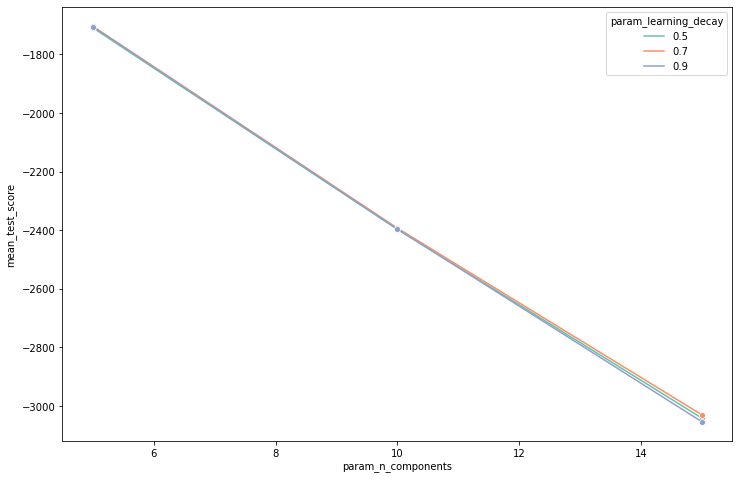

In [ ]:
results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o'
            )

plt.show()

## Tópico dominante em cada documento

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df2))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.070000,0.710000,0.070000,0.070000,0.070000,1
Doc1,0.070000,0.710000,0.070000,0.070000,0.070000,1
Doc2,0.860000,0.030000,0.030000,0.030000,0.030000,0
Doc3,0.030000,0.870000,0.030000,0.030000,0.030000,1
Doc4,0.020000,0.020000,0.910000,0.020000,0.020000,2
Doc5,0.790000,0.050000,0.050000,0.050000,0.050000,0
Doc6,0.030000,0.030000,0.030000,0.030000,0.890000,4
Doc7,0.030000,0.030000,0.480000,0.030000,0.430000,2
Doc8,0.030000,0.030000,0.030000,0.030000,0.880000,4
Doc9,0.030000,0.030000,0.030000,0.030000,0.880000,4


## Quantidade de Documentos em Cada Tópico

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,558
1,4,510
2,1,506
3,2,486
4,0,450


## Visualizando o modelo LDA com o pyLDAvis

In [ ]:
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html') 
pyLDAvis.display(panel)

## Top 30 palavras por tópico

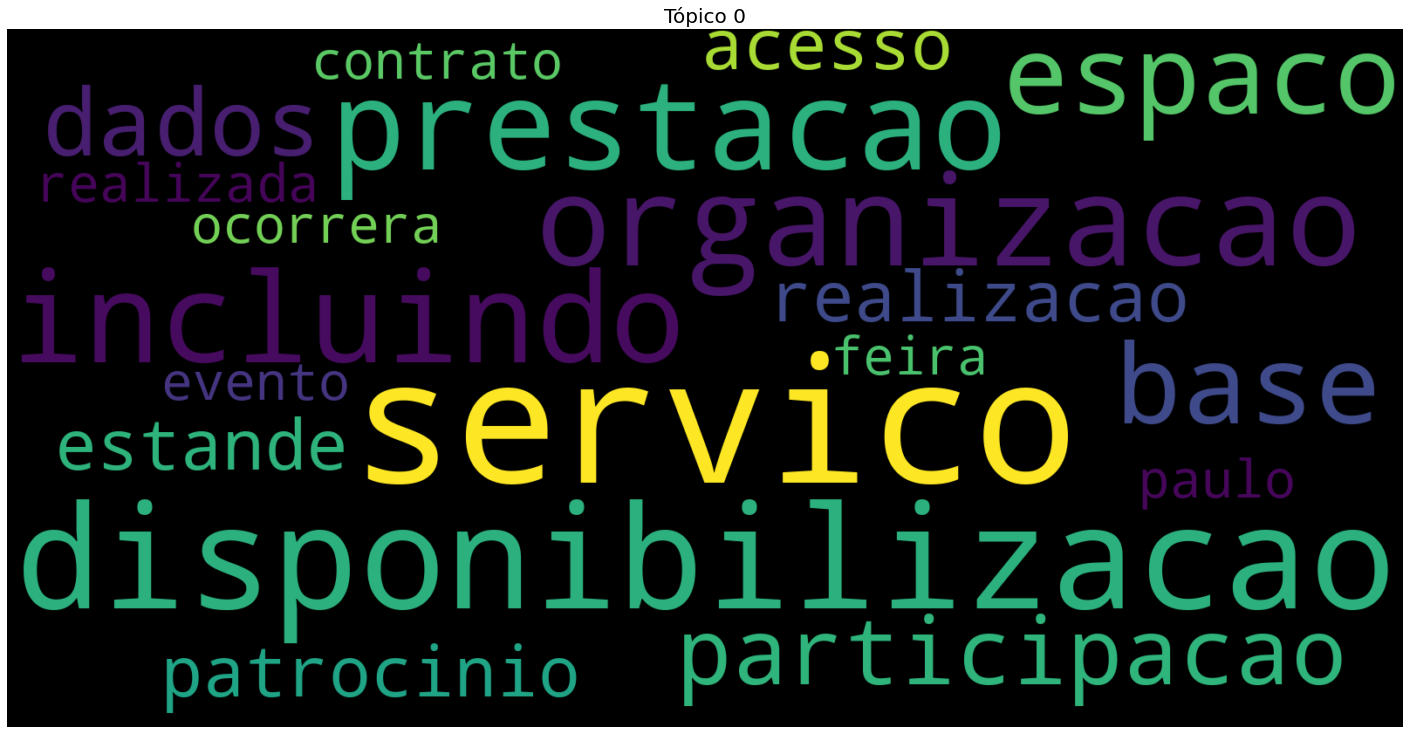

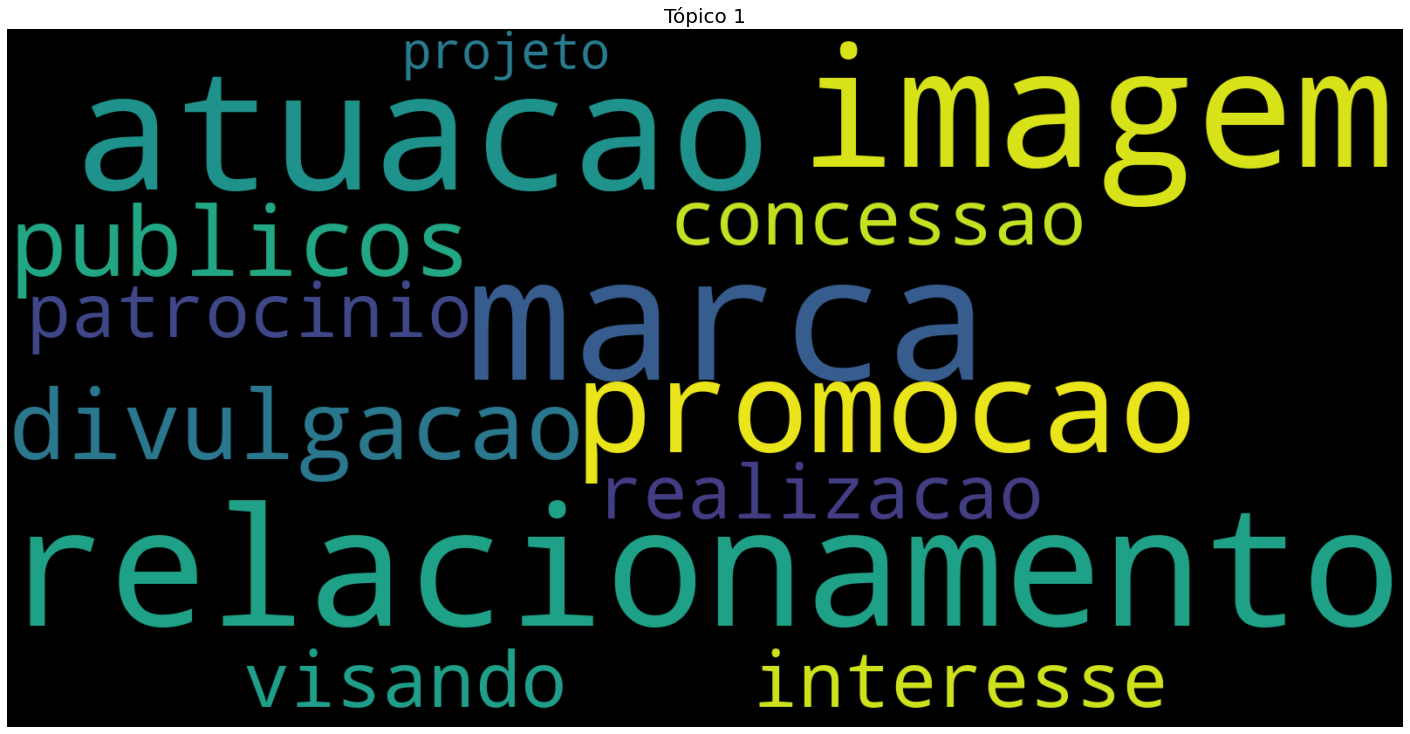

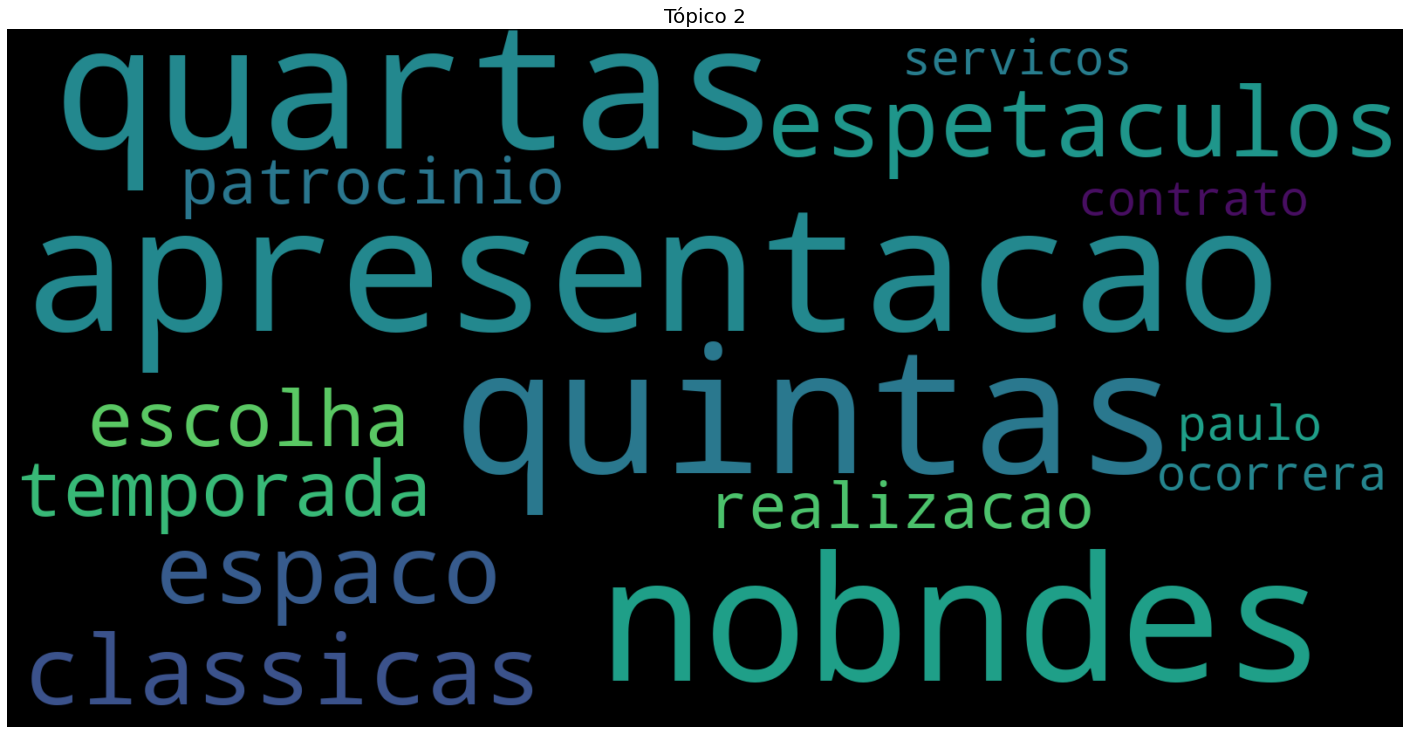

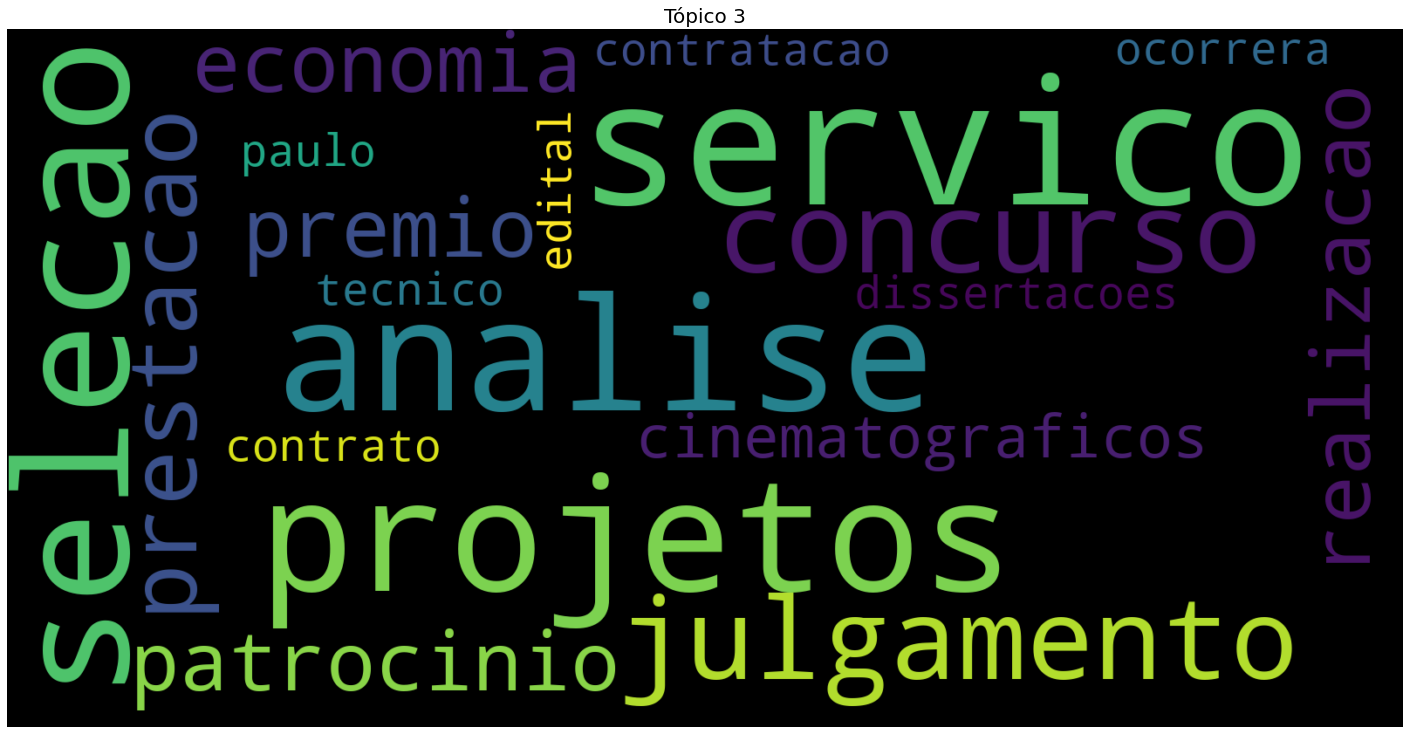

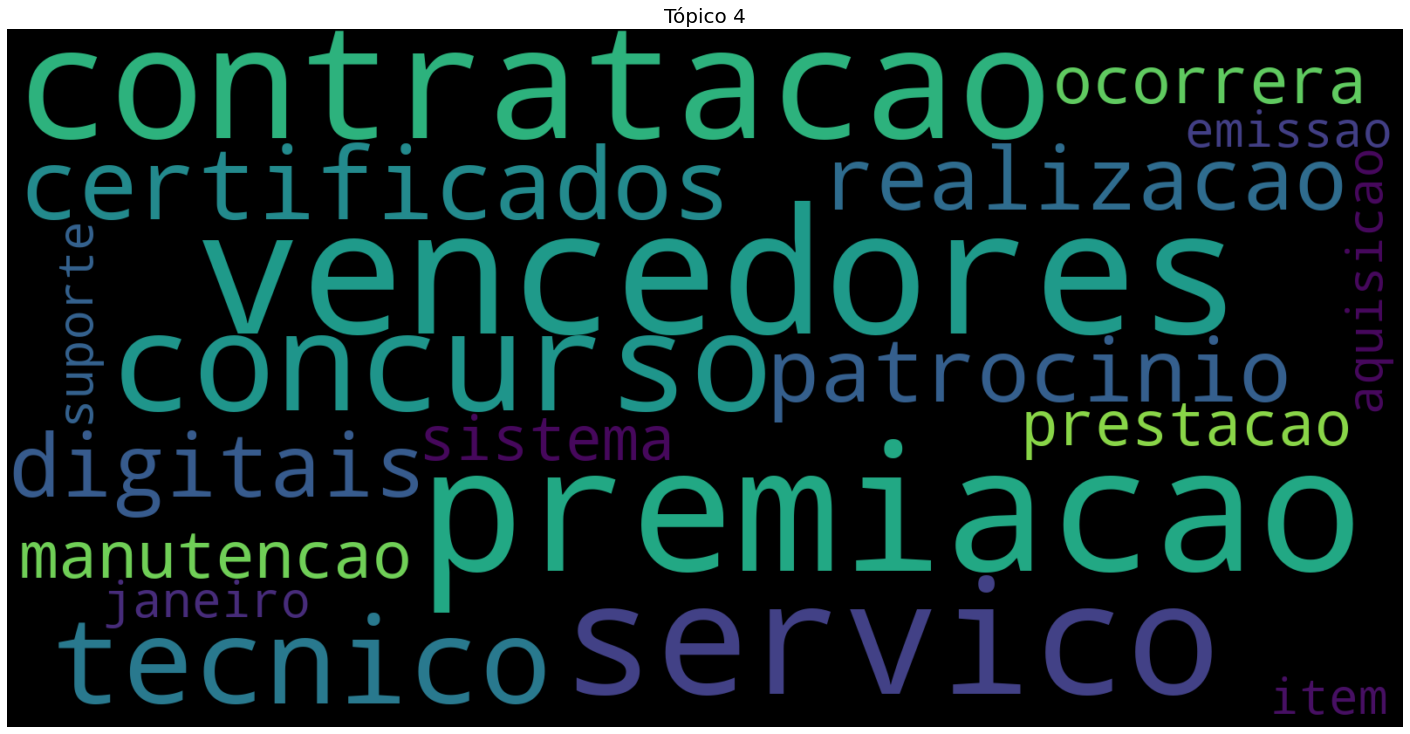

In [ ]:
vocab = vectorizer.get_feature_names()

# data_vectorized
topic_words = {}
n_top_words = 30

for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:n_top_words]

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]

    
for topic, words in topic_words.items():
    words = ', '.join(words)
    words = str(words)
    cloud1 = WordCloud(background_color='black',width=1600, height=800,max_font_size=200,max_words=20,collocations=False).generate(words)

    plt.figure(figsize = (20,10))
    plt.imshow(cloud1, interpolation='bilinear')
    plt.title('Tópico ' + str(topic), fontsize=20)
    plt.axis('off')
    plt.tight_layout(pad=0)